# Training a Vision Transformer (ViT) from Scratch on CIFAR-10

This notebook demonstrates the complete end-to-end process of training a Vision Transformer (ViT) from scratch. 

**CRITICAL CAVEAT:** ViTs are notoriously data-hungry. This notebook trains a custom "ViT-Lite" model on the **CIFAR-10** dataset (32x32 images). Due to the small scale of the data, the final accuracy **will not be state-of-the-art**. A simple ResNet would perform much better. 

The purpose of this guide is to understand the **training mechanics** and data flow, not to achieve peak performance, which would require pre-training on a massive dataset (e.g., JFT-300M or ImageNet-21k).

## Step 1: Install and Import Libraries

In [1]:
#!pip install torch torchvision matplotlib numpy tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Step 2: Load and Pre-process CIFAR-10 Dataset

CIFAR-10 images are 32x32. We will use a `patch_size` of 4, which gives us (32/4) * (32/4) = 8 * 8 = 64 patches. This is a reasonable sequence length for the Transformer.

We *must* use data augmentation to help the ViT generalize, as it has no built-in spatial bias.

In [2]:
IMG_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 10
BATCH_SIZE = 64

# CIFAR-10 Normalization stats
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

# Training transforms with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Test transforms (only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

## Step 3: Define the ViT Model Components

We will re-use the same modular components from the previous notebook (PatchEmbedding, Attention, EncoderBlock), as the architecture is identical.

In [3]:
class PatchEmbedding(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, D, H/P, W/P)
        x = x.flatten(2)   # (B, D, N_patches)
        x = x.transpose(1, 2) # (B, N_patches, D)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding
        return x

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention Mechanism"""
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, D)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class ViTEncoderBlock(nn.Module):
    """Transformer Encoder Block"""
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mha = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.mha(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    """The full Vision Transformer Model"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_layers, 
                 num_heads, mlp_dim, num_classes, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_drop = nn.Dropout(dropout)
        
        self.encoder_layers = nn.ModuleList([
            ViTEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)
        
        for layer in self.encoder_layers:
            x = layer(x)
            
        x = self.norm(x)
        cls_output = x[:, 0] # Get the [CLS] token output
        output = self.mlp_head(cls_output)
        return output

## Step 4: Configure the "ViT-Lite" Model and Optimizer

We will define a "Lite" model with fewer parameters than the standard `ViT-Base` to make it trainable on this small dataset.

In [4]:
# ViT-Lite Configuration
config = {
    "img_size": 32,
    "patch_size": 4,
    "in_channels": 3,
    "embed_dim": 256,      # Smaller embedding dim (ViT-Base is 768)
    "num_layers": 6,         # Fewer layers (ViT-Base is 12)
    "num_heads": 4,          # Fewer heads (ViT-Base is 12)
    "mlp_dim": 512,        # Smaller MLP dim (ViT-Base is 3072)
    "num_classes": 10,
    "dropout": 0.1
}

model = VisionTransformer(**config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params / 1e6:.2f}M")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

NUM_EPOCHS = 30 # Set to 30-50 for a reasonable run

Total Trainable Parameters: 3.20M


## Step 5: The Training and Validation Loop

We will now write the loops to train the model and validate it on the test set after each epoch. We will store the results to plot them later.

In [5]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
        
    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, test_loader, criterion)
    scheduler.step() # Update learning rate
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

print("Training finished.")

Starting training...


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/30] | Train Loss: 1.8456 | Val Loss: 1.5632 | Val Acc: 43.84%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/30] | Train Loss: 1.5725 | Val Loss: 1.4120 | Val Acc: 49.20%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/30] | Train Loss: 1.4690 | Val Loss: 1.3860 | Val Acc: 50.04%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/30] | Train Loss: 1.3933 | Val Loss: 1.2563 | Val Acc: 54.49%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/30] | Train Loss: 1.3436 | Val Loss: 1.2266 | Val Acc: 55.71%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/30] | Train Loss: 1.2945 | Val Loss: 1.1851 | Val Acc: 56.88%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/30] | Train Loss: 1.2581 | Val Loss: 1.1797 | Val Acc: 57.89%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/30] | Train Loss: 1.2236 | Val Loss: 1.1358 | Val Acc: 59.12%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/30] | Train Loss: 1.1922 | Val Loss: 1.1328 | Val Acc: 59.33%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/30] | Train Loss: 1.1681 | Val Loss: 1.1028 | Val Acc: 60.60%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11/30] | Train Loss: 1.1321 | Val Loss: 1.0680 | Val Acc: 61.79%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [12/30] | Train Loss: 1.1111 | Val Loss: 1.0859 | Val Acc: 61.35%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [13/30] | Train Loss: 1.0871 | Val Loss: 1.0280 | Val Acc: 63.31%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [14/30] | Train Loss: 1.0648 | Val Loss: 1.0048 | Val Acc: 64.28%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [15/30] | Train Loss: 1.0454 | Val Loss: 1.0138 | Val Acc: 64.12%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [16/30] | Train Loss: 1.0248 | Val Loss: 0.9687 | Val Acc: 65.45%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [17/30] | Train Loss: 1.0056 | Val Loss: 0.9447 | Val Acc: 66.44%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [18/30] | Train Loss: 0.9852 | Val Loss: 0.9677 | Val Acc: 65.83%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [19/30] | Train Loss: 0.9689 | Val Loss: 0.9285 | Val Acc: 66.73%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [20/30] | Train Loss: 0.9558 | Val Loss: 0.9225 | Val Acc: 67.48%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [21/30] | Train Loss: 0.9420 | Val Loss: 0.8916 | Val Acc: 68.74%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [22/30] | Train Loss: 0.9266 | Val Loss: 0.8846 | Val Acc: 68.55%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [23/30] | Train Loss: 0.9085 | Val Loss: 0.8829 | Val Acc: 68.91%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [24/30] | Train Loss: 0.8993 | Val Loss: 0.8626 | Val Acc: 69.58%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [25/30] | Train Loss: 0.8821 | Val Loss: 0.8614 | Val Acc: 69.79%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [26/30] | Train Loss: 0.8744 | Val Loss: 0.8745 | Val Acc: 69.65%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [27/30] | Train Loss: 0.8637 | Val Loss: 0.8534 | Val Acc: 70.10%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [28/30] | Train Loss: 0.8550 | Val Loss: 0.8343 | Val Acc: 71.21%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [29/30] | Train Loss: 0.8463 | Val Loss: 0.8320 | Val Acc: 71.16%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [30/30] | Train Loss: 0.8364 | Val Loss: 0.8287 | Val Acc: 71.14%
Training finished.


## Step 6: Plot Training Results

The "results" of training are the learning curves. We will plot how the loss and accuracy changed over time.

In [6]:
#!pip install ipywidgets

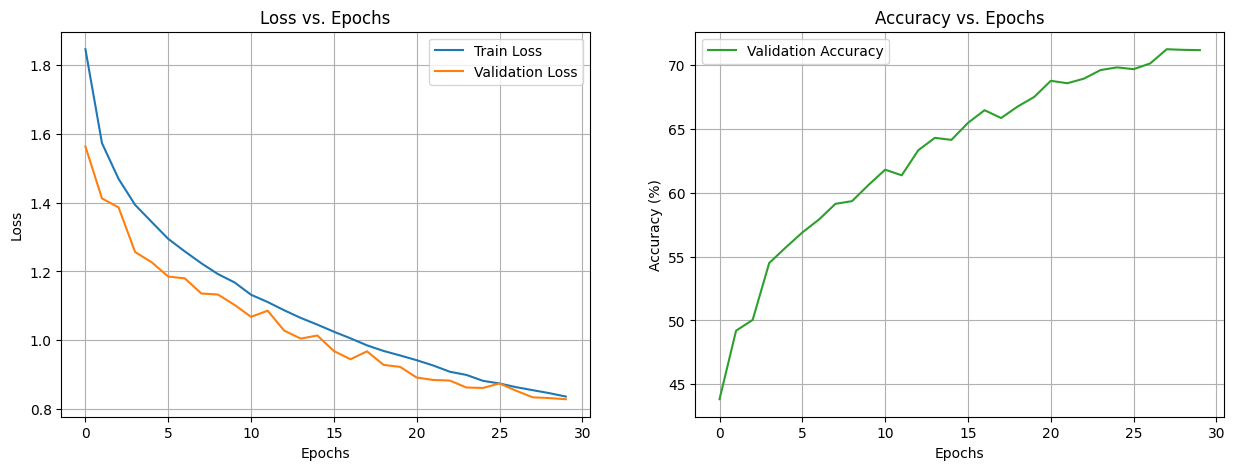

Final Validation Accuracy: 71.14%


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting Accuracy
ax2.plot(history['val_acc'], label='Validation Accuracy', color='C2')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.show()

print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")

## Step 7: Plot Predictions on Test Images

Finally, let's grab a batch of test images and plot the model's predictions.

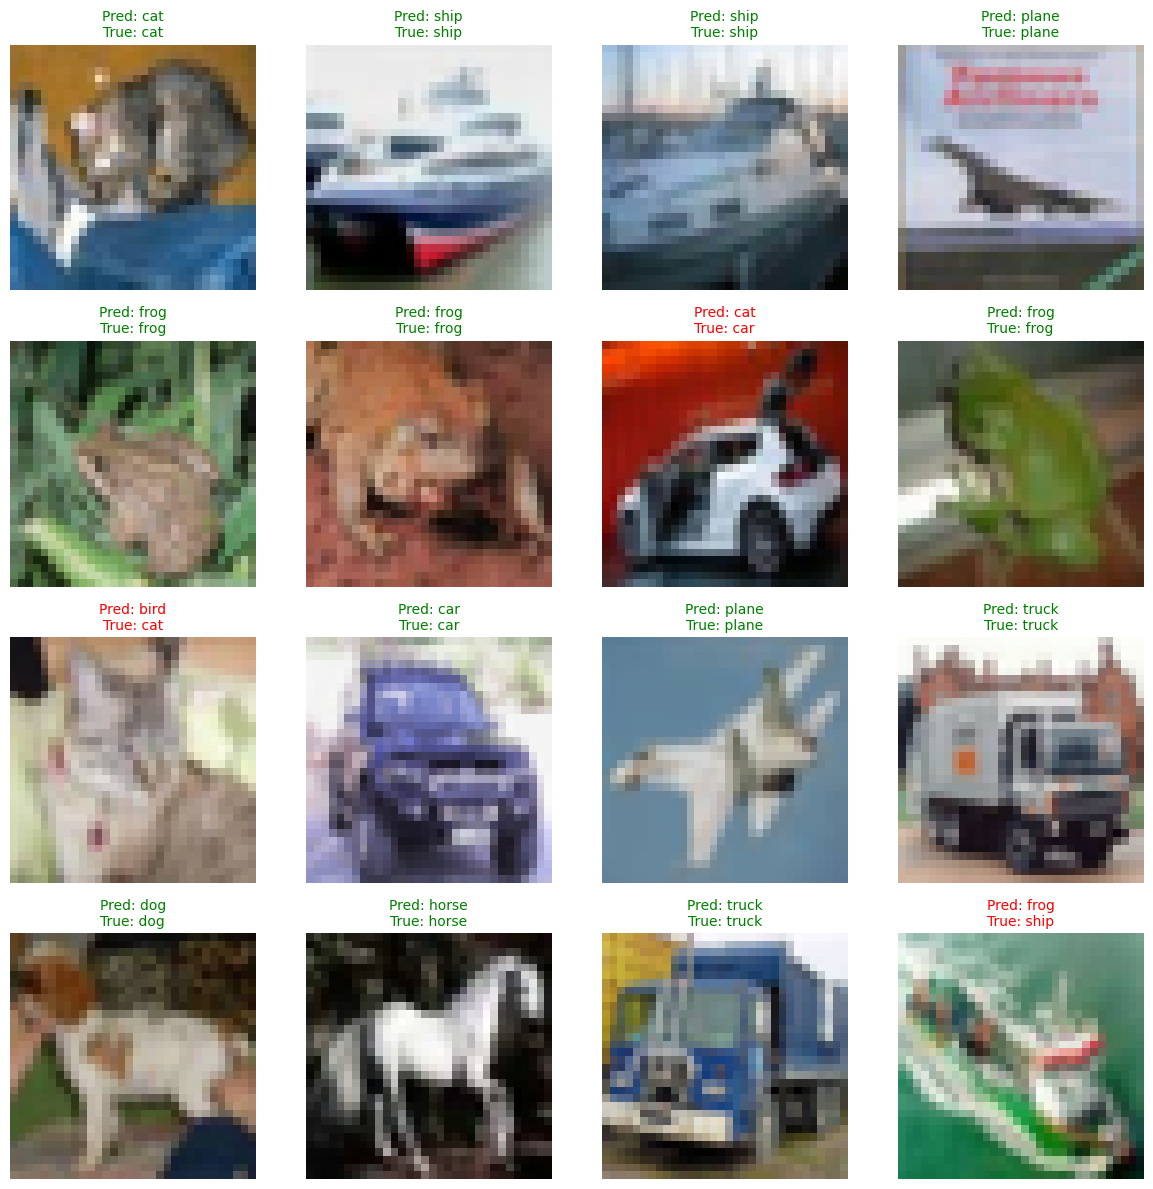

In [8]:
# Helper function to un-normalize and display an image
def imshow(img):
    img = img.cpu() / 2 + 0.5  # Un-normalize (this is a rough approximation)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot the images
plt.figure(figsize=(12, 12))
for i in range(16): # Plot 16 images
    plt.subplot(4, 4, i + 1)
    
    # Un-normalize using the specific CIFAR-10 stats for display
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')
    
    pred_label = classes[predicted[i]]
    true_label = classes[labels[i]]
    
    # Set title color
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)

plt.tight_layout()
plt.show()

## Analysis and Conclusion

You will likely observe that the final validation accuracy is low (perhaps 50-70%), which is far behind a simple CNN on CIFAR-10. 

**This is the expected outcome.**

It demonstrates the key property of Vision Transformers: their performance is highly dependent on the scale of data. Without the built-in spatial priors of a CNN, the ViT must learn all spatial relationships from scratch, and a small dataset like CIFAR-10 is insufficient for it to generalize well. This is precisely *why* the standard practice is to use large-scale pre-training.